## Imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

import keras
from keras.models import Sequential,Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Concatenate, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras import backend as K

import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

batch_size = 512
num_classes = 10
img_rows, img_cols = 28, 28

Using TensorFlow backend.


## Load data

In [3]:
X_train, y_train = None, None
with open("../data/train_info", "rb") as fin:
    data = pickle.load(fin)
    X_train, y_train = data["data"], data["labels"]

X_test, y_test = None, None
with open("../data/test_info", "rb") as fin:
    data = pickle.load(fin)
    X_test, y_test = data["data"], data["labels"]

In [4]:
x_train_skel_features = np.load('data_train.npy')
x_test_skel_features = np.load('data_test.npy')

input_dim_skelet = (x_train_skel_features.shape[1],)

FileNotFoundError: [Errno 2] No such file or directory: 'data_train.npy'

## Create data for network

In [4]:
x_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape_cnn = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Create f1 score

In [5]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Generate model

In [6]:
model_cnn_input = Input(input_shape_cnn)
cnn_layer1 = Conv2D(32, (3, 3),
             activation='relu',
             input_shape=input_shape_cnn)(model_cnn_input)

cnn_layer2 = Conv2D(64, (3, 3), activation='relu')(cnn_layer1)
cnn_layer3 = MaxPooling2D(pool_size=(2, 2))(cnn_layer2)
cnn_layer4 = Dropout(0.25)(cnn_layer3)
cnn_layer5 = Flatten()(cnn_layer4)
cnn_layer6 = Dense(128, activation='relu')(cnn_layer5)

features_input = Input(input_dim_skelet)
features_layer1 = Dense(32, input_dim=input_dim_skelet)(features_input)

merged = Concatenate()([cnn_layer6, features_layer1])
layer1 = Dropout(0.5)(merged)
output_layer = Dense(num_classes, activation='softmax')(layer1)

model = Model(inputs=[model_cnn_input, features_input], outputs=output_layer)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy', f1])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 24, 24, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 12, 12, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dropout_1 

## Create callbacks

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('model_cnn_plus_features.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=3, verbose=1)
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

callbacks=[early_stopping, model_checkpoint, reduce_lr, tbCallBack]

## Fit model

In [8]:
history = model.fit([x_train, x_train_skel_features], y_train,
          batch_size=batch_size,
          epochs=10000,
          callbacks=callbacks,
          verbose=1,
          validation_data=([x_test, x_test_skel_features], y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10000
60000/60000 [==============================] - 5s 78us/step - loss: 11.0892 - acc: 0.3026 - f1: 0.3026 - val_loss: 7.0200 - val_acc: 0.5602 - val_f1: 0.5602

Epoch 00001: val_loss improved from inf to 7.01998, saving model to best_model.h5
Epoch 2/10000
60000/60000 [==============================] - 3s 45us/step - loss: 7.3606 - acc: 0.5386 - f1: 0.5386 - val_loss: 5.9796 - val_acc: 0.6255 - val_f1: 0.6255

Epoch 00002: val_loss improved from 7.01998 to 5.97962, saving model to best_model.h5
Epoch 3/10000
60000/60000 [==============================] - 3s 44us/step - loss: 6.2503 - acc: 0.6060 - f1: 0.6060 - val_loss: 4.0188 - val_acc: 0.7427 - val_f1: 0.7427

Epoch 00003: val_loss improved from 5.97962 to 4.01883, saving model to best_model.h5
Epoch 4/10000
60000/60000 [==============================] - 3s 46us/step - loss: 4.5579 - acc: 0.7082 - f1: 0.7083 - val_loss: 3.2228 - val_acc: 0.7925 - val_f1: 0.7925

Epoch 00004

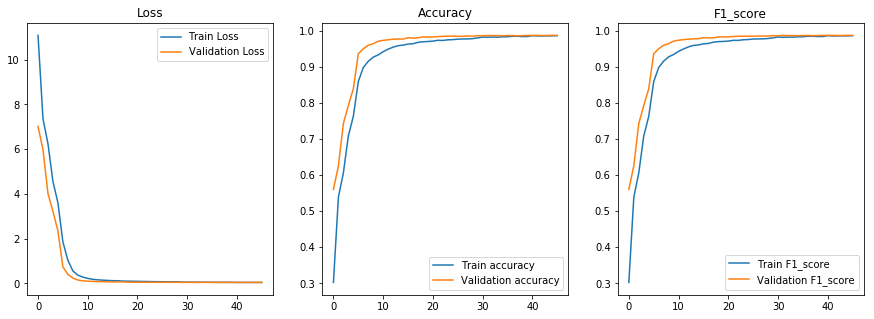

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].set_title('Loss')
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss")
ax[1].set_title('Accuracy')
ax[1].plot(history.epoch, history.history["acc"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax[2].set_title('F1_score')
ax[2].plot(history.epoch, history.history["f1"], label="Train F1_score")
ax[2].plot(history.epoch, history.history["val_f1"], label="Validation F1_score")
ax[0].legend()
ax[1].legend()
ax[2].legend()

## Score model

In [10]:
model = load_model('model_cnn_plus_features.h5', custom_objects={'f1': f1})
score = model.evaluate([x_test, x_test_skel_features], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test f1_score:', score[2])

Test loss: 0.04591501131900768
Test accuracy: 0.9864
Test f1_score: 0.9867530937194824
